# **DTSA 5011 Final Project-BBC News Classification Problem**
### **Logistic regression or LSTM**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import nltk
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation, digits, printable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
colors = ['#247BA0', '#F6511D', '#7FB800', '#FFB400', '#F25F5C', '#50514F']

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## **Brief description of the problem and data**

This project is based on one of the competitions on kaggle, BBC News Classification - News Articles Categorization.

https://www.kaggle.com/competitions/learn-ai-bbc/overview

The data from kaggle consists of news article contents with category label and the problem that this project is trying to solve is to classify news articles into the right category. Since deep learning is a good way to deal with natural language processing problem, I am going to take this chance to build a logistic regression and a LSTM(Long Short-Term Memory) model to solve the classification problem, and compare the result for inspiration.

## **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [ ]:
bbc_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DTSA 5011 Final Project-BBC News Classification Problem/BBC News Train.csv')
bbc_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DTSA 5011 Final Project-BBC News Classification Problem/BBC News Test.csv')

In [ ]:
bbc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


First, we take a look at the training data, we can see that there is no missing data in the dataset. There are 1490 news articles in the dataset, and each row consists of the article id, content and category.

In [ ]:
bbc_train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
bbc_train_df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

There are five categories of the articles. The training dataset seems to be balance, the number of sport and business articles are slightly more than other categories.

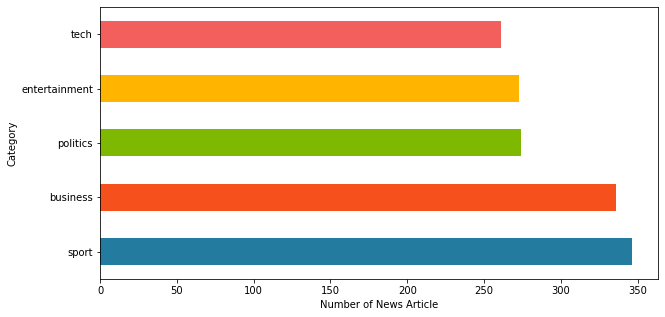

In [ ]:
plt.figure(figsize=(10, 5))
ax=bbc_train_df['Category'].value_counts().plot(kind='barh')
for patch,color in zip(ax.patches, colors):
    patch.set_facecolor(color)
plt.ylabel('Category')
plt.xlabel('Number of News Article')
plt.style.use('fivethirtyeight')
plt.show()

In the following, we transform the category into category id and text into vector for furture analysis.

In [ ]:
#Transforming categories in to ids
bbc_train_df['Category_id'] = bbc_train_df['Category'].factorize()[0]
category_id_df = bbc_train_df[['Category', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Category_id', 'Category']].values)

In [ ]:
#Using scikit learn TfidfVectorizer function to extract features from raw text
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(bbc_train_df['Text']).toarray()
labels = bbc_train_df['Category_id']

We use chi-squared test to find out the most correlated words of each category. We can see the top three unigrams and bigrams of each category, it seems that the result is quite reasonable.

In [ ]:
N = 3
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


Finally, we use t-SNE to tranform the feature vector into 2 dimensions to have a better understanding of the data. We can see that most of the data is clearly separated into five categories, and this means the training data is quite clean and machine learning model should get a good result.

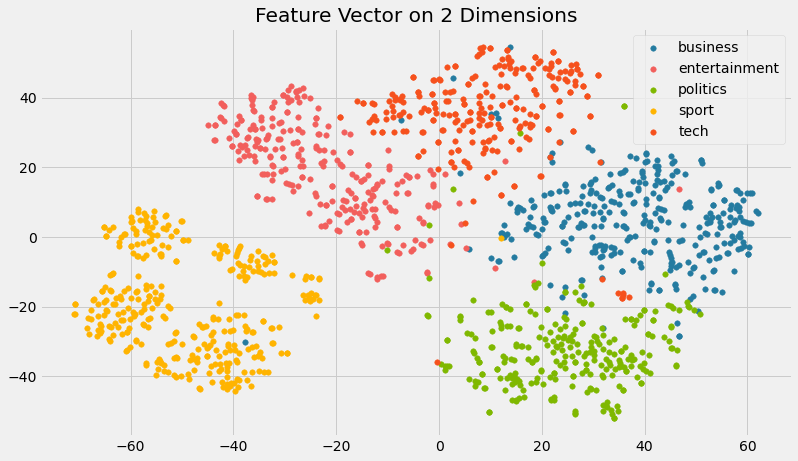

In [ ]:
projected_features = TSNE(n_components = 2, random_state = 0).fit_transform(features)
plt.figure(figsize=(12, 7))
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s = 30, c = colors[category_id], label = category)
plt.title("Feature Vector on 2 Dimensions")
plt.legend()

Now, we are going to clean the text so that the machine can understand the text better.

In [ ]:
bbc_train_df['clean_text'] = bbc_train_df['Text'].str.lower() #Transforming all the letters into lower letters
stop_words = list(stopwords.words('english')) #Using for removing stop words
punctuation = list(punctuation) #Using for removing punctuation
printable = list(printable) #Using for removing non printable characters
digits = list(digits) #Using for removing digits
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in bbc_train_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words and word not in punctuation]
    clean_temp = ' '.join(clean_temp)
    clean_punctuation_non_printable_digits = [char for char in clean_temp if char not in punctuation and char in printable and char not in digits]
    clean_temp = ''.join(clean_punctuation_non_printable_digits)
    clean_text_list.append(clean_temp)
bbc_train_df['clean_text'] = pd.Series(clean_text_list)

In [ ]:
bbc_train_df

,ArticleId,Text,Category,Category_id,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0,worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,0,german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,0,bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,1,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,0,enron boss m payout eighteen former enron dire...
...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,4,double eviction big brother model caprice holb...
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4,dj double act revamp chart show dj duo jk joel...
1487,1590,weak dollar hits reuters revenues at media gro...,business,0,weak dollar hit reuters revenue medium group r...
1488,1587,apple ipod family expands market apple has exp...,tech,1,apple ipod family expands market apple expande...


Then we use the transform the text into feature vector again based on the clean text.

In [61]:
features = tfidf.fit_transform(bbc_train_df['clean_text']).toarray()

## **Model Architecture and Results**

First, we build a simple logistic regression model with scikit learn and see the result

In [50]:
lr_model = LogisticRegression(random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
lr_model.fit(X_train, y_train)
y_pred_proba = lr_model.predict_proba(X_test)
y_pred = lr_model.predict(X_test)

Text(0.5, 13.779999999999973, 'Predicted')

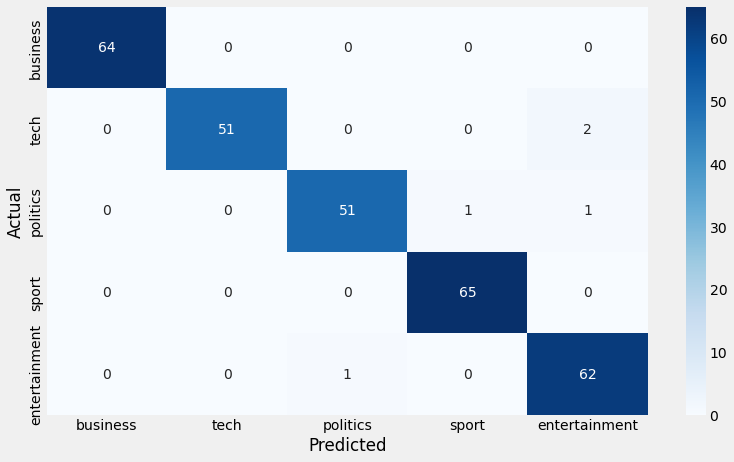

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_id_df['Category'], yticklabels=category_id_df['Category'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

The logistic regression model gets a very good performance, it scores 98% accuracy from the test dataset.

In [ ]:
lr_model.score(X_test, y_test)

0.9832214765100671

Now we are going to build the LSTM model. My way to doing this is assuming there are around 3,000 frequent words and turning each word into a 64-length vector, so I first added an embedding layer to deal with the text. Then, I added two LSTM(Long Short-Term Memory) layers with 100 units. Finally, I added and dropout layer to prevent overfitting and a dense layer with softmax activation function.

Finally, since this is a categorical classification problem, I chose 'categorical_crossentropy' as the loss function, and using learning rate of 0.0005.

In [79]:
#Using Tokenizer to tokenizer the text and spliting the data for training the LSTM model
n_most_common_words = 3000
max_len = 130
tokenizer = Tokenizer(num_words = n_most_common_words)
tokenizer.fit_on_texts(bbc_train_df['clean_text'])
sequences = tokenizer.texts_to_sequences(bbc_train_df['clean_text'])
word_index = tokenizer.word_index
features_keras = pad_sequences(sequences, maxlen = max_len)

In [ ]:
labels_keras = to_categorical(labels, num_classes=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_keras, labels_keras, test_size=0.2, random_state=0)

In [ ]:
model = Sequential([
    layers.Embedding(3000, 64, input_length = X_train.shape[1]),
    layers.Dropout(0.2),
    layers.LSTM(100, dropout = 0.2, return_sequences = True, recurrent_dropout = 0.4),
    layers.Dropout(0.2),
    layers.LSTM(100, dropout = 0.2, recurrent_dropout = 0.4),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(0.0005),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 130, 64)           192000    
                                                                 
 dropout_3 (Dropout)         (None, 130, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 130, 100)          66000     
                                                                 
 dropout_4 (Dropout)         (None, 130, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience = 3)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.001)
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks = [callback, reduce_lr])

Epoch 1/30
30/30 [==============================] - 22s 545ms/step - loss: 1.6019 - accuracy: 0.2865 - val_loss: 1.5818 - val_accuracy: 0.4142 - lr: 5.0000e-04
Epoch 2/30
30/30 [==============================] - 17s 556ms/step - loss: 1.2823 - accuracy: 0.4491 - val_loss: 1.0826 - val_accuracy: 0.4561 - lr: 5.0000e-04
Epoch 3/30
30/30 [==============================] - 16s 523ms/step - loss: 1.0158 - accuracy: 0.4879 - val_loss: 0.9561 - val_accuracy: 0.5523 - lr: 5.0000e-04
Epoch 4/30
30/30 [==============================] - 16s 527ms/step - loss: 0.7260 - accuracy: 0.7534 - val_loss: 0.7593 - val_accuracy: 0.7490 - lr: 5.0000e-04
Epoch 5/30
30/30 [==============================] - 17s 577ms/step - loss: 0.6180 - accuracy: 0.7786 - val_loss: 0.4329 - val_accuracy: 0.8870 - lr: 5.0000e-04
Epoch 6/30
30/30 [==============================] - 16s 522ms/step - loss: 0.3807 - accuracy: 0.8961 - val_loss: 0.3793 - val_accuracy: 0.8661 - lr: 5.0000e-04
Epoch 7/30
30/30 [======================

In [44]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

Text(0.5, 42.0, 'Predicted')

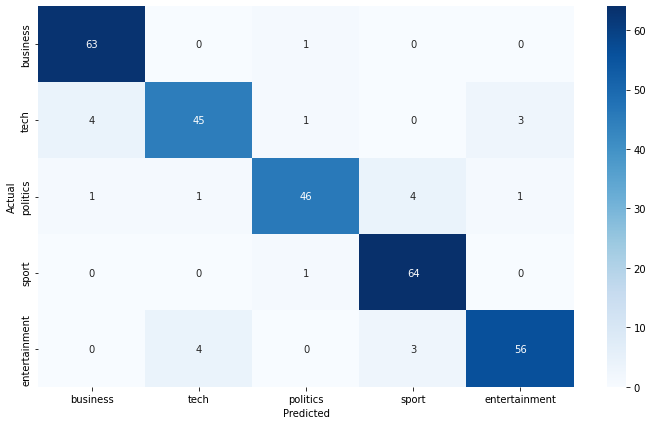

In [49]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_id_df['Category'], yticklabels=category_id_df['Category'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

The LSTM model also gets a good performance, it scores 92.6% accuracy from the test dataset, but from the confusion matrix and the accuracy score, we can know that the logistic regression is actually better than the LSTM model.

In [ ]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 2s 194ms/step - loss: 0.2713 - accuracy: 0.9262


[0.2713319957256317, 0.926174521446228]

Finally, we are going to make submissions based on the two models to see which one can get a better result.

In [51]:
#Cleaning the submission dataset for the submission dataset
bbc_test_df['clean_text'] = bbc_test_df['Text'].str.lower() #Transforming all the letters into lower letters
stop_words = list(stopwords.words('english')) #Using for removing stop words
punctuation = list(punctuation) #Using for removing punctuation
printable = list(printable) #Using for removing non printable characters
digits = list(digits) #Using for removing digits
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in bbc_test_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words and word not in punctuation]
    clean_temp = ' '.join(clean_temp)
    clean_punctuation_non_printable_digits = [char for char in clean_temp if char not in punctuation and char in printable and char not in digits]
    clean_temp = ''.join(clean_punctuation_non_printable_digits)
    clean_text_list.append(clean_temp)
bbc_test_df['clean_text'] = pd.Series(clean_text_list)

In [62]:
#Predicting the test dataset with the logistic regression model
features_submission_lr = tfidf.transform(bbc_test_df['clean_text']).toarray()
y_pred = lr_model.predict(features_submission_lr)
bbc_test_df['Category'] = y_pred
bbc_test_df.replace({'Category': id_to_category}, inplace = True)

In [76]:
bbc_test_df[['ArticleId', 'Category']].to_csv('/content/drive/MyDrive/Colab Notebooks/DTSA 5011 Final Project-BBC News Classification Problem/submission_lr.csv', index = False)

In [80]:
#Predicting the test dataset with the LSTM model
sequences = tokenizer.texts_to_sequences(bbc_test_df['clean_text'])
word_index = tokenizer.word_index
features_submission_keras = pad_sequences(sequences, maxlen = max_len)
y_pred = np.argmax(model.predict(features_submission_keras), axis=1)
bbc_test_df['Category'] = y_pred
bbc_test_df.replace({'Category': id_to_category}, inplace = True)

In [86]:
bbc_test_df[['ArticleId', 'Category']].to_csv('/content/drive/MyDrive/Colab Notebooks/DTSA 5011 Final Project-BBC News Classification Problem/submission_LSTM.csv', index = False)

The submission of logistic regression scores almost 98% accuracy, but the submission of LSTM model only scores around 88% accuracy.

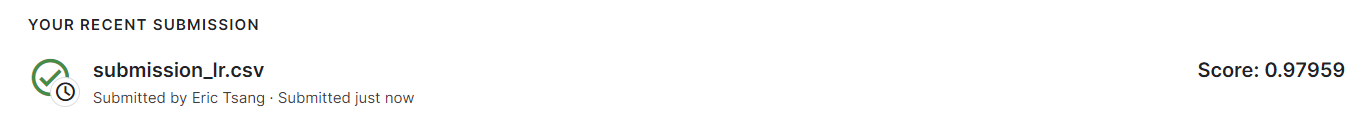

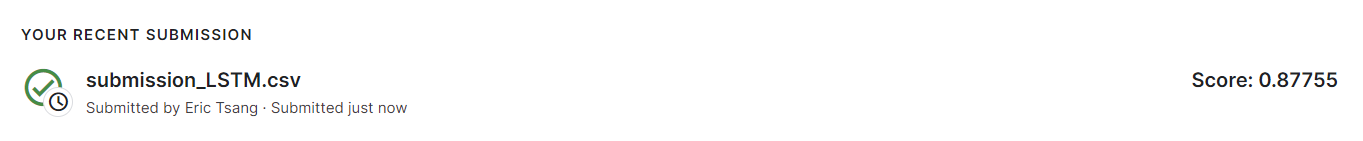

## **Conclusion**

In this project, we built a logistic regression model and a LSTM model and we can learn a few things from that.

First, logistic regression is just like a single layer neural network, so it is very simple by comparing with the LSTM model. I think the LSTM model can work better by trying more combinations of parameters, but it is time consuming for training the model by comparing with the logistic regression model.

Second, remember the t-SNE graph, the data is quite clean so that a logistic regression can have a great performance. The LSTM  model may be suitable for dealing with more complex and non-linear problems.

Finally, I think it is better to solve the problem with a simple model first. If a simple model can get a acceptable result, it may not be worthy to spend more time to build a more complex model. The choice of model is very important, nowadays there are many tools to help us evaluate different models in without many pains. Like Pycaret, it can evaluates the performance of all the models available in the model library using cross-validation, which can help us to make faster and better decisions of the choice of model.